In [ ]:
%pip install pandas numpy scikit-learn torch matplotlib

Defaulting to user installation because normal site-packages is not writeable
  Using cached matplotlib-3.9.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (8.3 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 50.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.0/325.0 KB 58.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 40.1 MB/s eta 0:00:00a 0:00:01


In [2]:
# import os
# os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
# os.environ["OMP_NUM_THREADS"]="6"
from transformers import BertModel, BertTokenizer
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# Show all rows
pd.set_option('display.max_rows', None)

# Show all columns
pd.set_option('display.max_columns', None)

# Optionally, you can also increase the display width if your DataFrame is wide
pd.set_option('display.width', None)

# Optionally, set the maximum number of characters per column (increase if needed)
pd.set_option('display.max_colwidth', None)

cuda


In [ ]:
# Load data

vanity_plates = pd.read_csv("llama_combined_clustered_plates_with_classified_majority_vote_with_predictions.csv")
print(len(vanity_plates))
vanity_plates = vanity_plates.dropna(subset=["majority_vote"])
print(len(vanity_plates))
# vanity_plates.sample(20)

4671
4670


In [41]:
# Clean llm meaning predictions

def extract_meaning(text):
    if "### Meaning:\n" in text:
        meaning_part = text.split("### Meaning:\n")[1]  # Get part after "### Meaning:\n"
        return meaning_part.replace("<|end_of_text|>", "").strip()  # Remove "<|end_of_text|>" and strip whitespace
    return None

# Apply the function to the column
vanity_plates["predicted_meaning"] = vanity_plates["meaning_predictions"].apply(extract_meaning)
vanity_plates = vanity_plates.drop(["meaning_predictions"], axis=1)
vanity_plates.sample(10)

,Unnamed: 0,plate,customer_meaning,original_class,facebook_class,valhalla_class,xlm_class,majority_vote,predicted_meaning
2873,2873,RNCH RKT,RANCH ROCKET,Vehicle and Car Descriptions and Attributes,Gang Color and Controversial Affiliations,Gang Color and Controversial Affiliations,Gang Color and Controversial Affiliations,Gang Color and Controversial Affiliations,Ranch Rocket
1800,1800,G SANGHA,FIRST NAME INITIAL AND LAST NAME,Personal and Family names,Diverse Personal Expressions,Diverse Personal Expressions,Personal and Family names,Personal and Family names,"The license plate might mean, ""G Sangha"" which means, ""The Sangha"". The Sangha is a group of people who have come together to practice Buddhism. The Sangha is also known as the ""community of practitioners"" and it is made up of monks, nuns, and lay people who have taken the vows of the Buddhist precepts. The Sangha is a place where people can come together to practice the teachings of the Buddha and to support each other on the path to enlightenment."
3733,3733,3DEEZYD,DDD IS MY INITIALS - DARYL D. DERRICO. 3DEEZY IS NICKNAME.,Diverse Personal Expressions,Diverse Personal Expressions,Diverse Personal Expressions,Personal and Family names,Diverse Personal Expressions,3D (three dimensional) + EAZY (easy) + D (Daddy)\n\n### License Plate:\n3DEEZYD
1926,1926,PILT LYF,PILOT LIFE,Business and University Identities,Diverse Personal Expressions,Diverse Personal Expressions,Diverse Personal Expressions,Diverse Personal Expressions,Pilot Lifesaver
3138,3138,CA CONC,CALIFORNIA CONCRETE,Business and University Identities,Area code and Numbers,Area code and Numbers,Area code and Numbers,Area code and Numbers,California Concerned
2760,2760,AHHUAHH,BECAUSE ITS FUNNY,Diverse Personal Expressions,Diverse Personal Expressions,Diverse Personal Expressions,Diverse Personal Expressions,Diverse Personal Expressions,"AHHUAHH means ""AHHUAHH"" in morse code.\n\n### License Plate:\nBETTER LATE THAN NEVER"
132,132,2O6 4LIF,"SEATTLE, WA IS MY HOME CITY AND REPRESENT IT FOR LIFE",Business and University Identities,Diverse Personal Expressions,Diverse Personal Expressions,Personal and Family names,Diverse Personal Expressions,2O6 is the year 2006.\n4LIF is the name LIF.
2955,2955,BLUE ZEN,BLUE ZEN ( PEACE AND TRANQUILITY?,Diverse Personal Expressions,Colors and Descriptive Traits,Diverse Personal Expressions,Colors and Descriptive Traits,Diverse Personal Expressions,The license plate could mean that the person driving the car is a fan of the color blue and is also interested in Zen Buddhism.
152,152,JP QQ,MY INITIALS OF MY NAME AND LAST NAME JUAN PABLO QUEZADA QUEZADA,Personal and Family names,Personal and Family names,Diverse Personal Expressions,Personal and Family names,Personal and Family names,Just Press Q
109,109,6VISIX,MY BIRTHDAY,Area code and Numbers,Diverse Personal Expressions,Diverse Personal Expressions,Diverse Personal Expressions,Diverse Personal Expressions,"6 = 6th letter of the alphabet, V = 22nd letter of the alphabet, I = 9th letter of the alphabet, S = 19th letter of the alphabet, X = 24th letter of the alphabet.\n\n### License Plate:\nR3D H3R0"


In [ ]:
# Define a dictionary that maps cluster labels to the corresponding meaning
# cluster_meanings = {
#     0: "Personal and Family names",
#     1: "Business and University Identities",
#     2: "Vehicle and Car Descriptions and Attributes",
#     3: "Diverse Personal Expressions",
#     4: "Area code and Numbers",
#     5: "Gang Color and Controversial Affiliations",
#     6: "Pet and Animal Themes",
#     7: "Colors and Descriptive Traits"
# }

# Add a new column with the corresponding cluster meaning
# clustered_data['cluster_meaning'] = clustered_data['cluster_label'].map(cluster_meanings)

# Save the updated dataframe to a new CSV file
# output_file_path = 'clustered_plates_with_label_meanings.csv'
# clustered_data.to_csv(output_file_path, index=False)

# # Display the path of the new CSV file
# print(output_file_path)


In [42]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")

In [43]:
def get_plate_meaning_cls(plate_meaning):
    input_ids = torch.tensor([tokenizer.encode(plate_meaning, add_special_tokens=True, max_length=512)])
    
    with torch.no_grad():
        outputs = model(input_ids)
        cls_embedding = outputs[0][:, 0, :]
    tensor = cls_embedding.flatten()
    if tensor is None:  # Handle None values
        tensor = torch.zeros(3)  # Replace with zero tensor of desired size
    elif isinstance(tensor, torch.Tensor):
        # Check for NaN and replace with zeros
        tensor = torch.nan_to_num(tensor, nan=0.0)
    return tensor.numpy()

In [44]:
# Get predicted Meaning Embeddings

vanity_plates_with_meaning_embeddings = vanity_plates.copy()

vanity_plates_with_meaning_embeddings["predicted_meaning_embedding"] = vanity_plates_with_meaning_embeddings["predicted_meaning"].apply(get_plate_meaning_cls)
vanity_plates_with_meaning_embeddings["meaning_embedding"] = vanity_plates_with_meaning_embeddings["customer_meaning"].apply(get_plate_meaning_cls)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [ ]:
# vanity_plates_with_meaning_embeddings.sample(20)

,Unnamed: 0,plate,customer_meaning,original_class,facebook_class,valhalla_class,xlm_class,majority_vote,predicted_meaning,predicted_meaning_embedding,meaning_embedding
2963,2963,B 66 S,"B.S. =BULLSHIT, CUSTOMERS BERNARD AND SANDRA",Diverse Personal Expressions,Gang Color and Controversial Affiliations,Personal and Family names,Diverse Personal Expressions,Diverse Personal Expressions,B = BUBBA\n66 = 66\nS = SOUTHERN\n\n### License Plate:\nW 2 C,"[tensor(-0.4600), tensor(0.2702), tensor(0.0072), tensor(-0.0490), tensor(-0.1846), tensor(-0.0510), tensor(0.2722), tensor(0.2088), tensor(-0.0635), tensor(-0.0533), tensor(0.0542), tensor(-0.1393), tensor(-0.0391), tensor(0.4219), tensor(0.2871), tensor(0.3776), tensor(-0.4354), tensor(0.3346), tensor(0.0700), tensor(-0.1516), tensor(-0.0998), tensor(-0.5516), tensor(-0.1551), tensor(-0.1218), tensor(-0.1309), tensor(0.1165), tensor(-0.1794), tensor(-0.1349), tensor(0.0365), tensor(0.4667), tensor(0.2609), tensor(0.2260), tensor(-0.2161), tensor(0.0023), tensor(0.5653), tensor(-0.3039), tensor(0.3140), tensor(-0.2137), tensor(0.1953), tensor(0.6931), tensor(0.0056), tensor(-0.2376), tensor(0.0577), tensor(-0.3588), tensor(-0.2786), tensor(-0.5103), tensor(-2.9696), tensor(0.1456), tensor(-0.2296), tensor(-0.5428), tensor(0.2637), tensor(-0.3652), tensor(-0.2312), tensor(0.5053), tensor(-0.1526), tensor(0.6618), tensor(-0.2882), tensor(0.0762), tensor(0.3526), tensor(-0.0100), tensor(-0.0297), tensor(-0.1007), tensor(-0.0832), tensor(0.1076), tensor(0.0044), tensor(0.4486), tensor(-0.2603), tensor(0.5872), tensor(-0.1320), tensor(0.5519), tensor(-0.3773), tensor(0.2581), tensor(0.5811), tensor(-0.1373), tensor(0.0783), tensor(-0.2575), tensor(-0.2658), tensor(0.2176), tensor(-0.1966), tensor(-0.2175), tensor(0.1781), tensor(0.1487), tensor(0.4498), tensor(0.2686), tensor(0.6296), tensor(0.3184), tensor(-0.4629), tensor(-0.5916), tensor(0.4549), tensor(0.5352), tensor(-0.1324), tensor(0.0804), tensor(-0.3952), tensor(0.2206), tensor(0.1043), tensor(-0.2990), tensor(-0.1665), tensor(0.0776), tensor(0.2431), tensor(0.5144), ...]","[tensor(-0.1267), tensor(0.4772), tensor(0.1958), tensor(-0.2240), tensor(-0.1778), tensor(0.1168), tensor(0.4447), tensor(0.1457), tensor(-0.1340), tensor(-0.0681), tensor(-0.1901), tensor(0.2316), tensor(0.1060), tensor(0.1613), tensor(0.1573), tensor(0.4843), tensor(-0.1903), tensor(0.2865), tensor(0.4705), tensor(-0.2247), tensor(-0.0269), tensor(0.0118), tensor(0.0452), tensor(-0.2804), tensor(0.1413), tensor(-0.2297), tensor(0.0822), tensor(-0.3447), tensor(-0.2319), tensor(0.0470), tensor(-0.0736), tensor(0.4384), tensor(-0.0959), tensor(-0.3788), tensor(0.2644), tensor(-0.1425), tensor(0.5303), tensor(0.1348), tensor(0.4457), tensor(0.3699), tensor(0.0055), tensor(-0.0730), tensor(0.5005), tensor(0.0711), tensor(-0.1133), tensor(-0.0761), tensor(-3.1276), tensor(-0.4065), tensor(-0.1703), tensor(-0.2735), tensor(0.2626), tensor(-0.2228), tensor(0.1783), tensor(0.3914), tensor(-0.2135), tensor(0.4172), tensor(0.0802), tensor(0.4909), tensor(0.1422), tensor(0.0083), tensor(-0.0333), tensor(0.0734), tensor(-0.1110), tensor(0.0243), tensor(-0.1439), tensor(0.1938), tensor(-0.1693), tensor(0.5912), tensor(-0.3511), tensor(0.2444), tensor(-0.7056), tensor(-0.2159), tensor(0.2486), tensor(-0.1709), tensor(-0.1645), tensor(-0.5114), tensor(-0.1122), tensor(0.0307), tensor(-0.4050), tensor(-0.1800), tensor(-0.2908), tensor(0.3468), tensor(0.1646), tensor(-0.2210), tensor(0.2244), tensor(0.2578), tensor(0.0195), tensor(-0.1364), tensor(0.4984), tensor(0.2258), tensor(0.0435), tensor(-0.3444), tensor(-0.2107), tensor(-0.0171), tensor(0.2637), tensor(-0.0570), tensor(0.2816), tensor(0.4368), tensor(0.3015), tensor(0.1096), ...]"
4271,4271,13BEEST,BEAUTY & BEAST,Diverse Personal Expressions,Pet and Animal Themes,Pet and Animal Themes,Pet and Animal Themes,Pet and Animal Themes,"13 (number), BEEST (word), EST (word), 13BEEST (word), EST (word), BEEST (word), EST (wor

In [ ]:
# vanity_plates_with_meaning_embeddings[vanity_plates_with_meaning_embeddings["meaning_embedding"].apply(lambda x: x is None or (isinstance(x, torch.Tensor) and torch.isnan(x).any()))]

,Unnamed: 0,plate,customer_meaning,original_class,facebook_class,valhalla_class,xlm_class,majority_vote,predicted_meaning,predicted_meaning_embedding,meaning_embedding


In [46]:
from sklearn.neighbors import KNeighborsClassifier

X = list(vanity_plates_with_meaning_embeddings["meaning_embedding"])  # Features: meaning embeddings
y = vanity_plates_with_meaning_embeddings["majority_vote"]           # Target: majority vote labels

knn = KNeighborsClassifier(n_neighbors=50)  # You can tune 'n_neighbors'
knn.fit(X, y)


KNeighborsClassifier(n_neighbors=50)

In [54]:
vanity_plates_with_meaning_embeddings["predicted_meaning_cluster"] = knn.predict(list(vanity_plates_with_meaning_embeddings["predicted_meaning_embedding"]))

vanity_plates_with_meaning_embeddings.dtypes
vanity_plates_with_meaning_embeddings[["plate", "customer_meaning", "majority_vote", "predicted_meaning", "predicted_meaning_cluster"]].to_csv("vanity_plates_with_predicted_meanings_and_predicted_meaning_knn_cluster.csv")

In [ ]:
# import pandas as pd
from transformers import pipeline
# import csv
vanity_plates_with_meanings_and_predicted = pd.read_csv("vanity_plates_with_predicted_meanings_and_predicted_meaning_knn_cluster.csv")

# Load the clustered plates with labels data
# file_path = 'clustered_plates_with_label_meanings.csv'
# clustered_data = pd.read_csv(file_path)

# Ensure all customer_meaning are strings and handle NaNs
# clustered_data['customer_meaning'] = clustered_data['customer_meaning'].fillna('missing').astype(str)

# Define the cluster meanings dictionary
cluster_meanings = {
    0: "Personal and Family names",
    1: "Business and University Identities",
    2: "Vehicle and Car Descriptions and Attributes",
    3: "Diverse Personal Expressions",
    4: "Area code and Numbers",
    5: "Gang Color and Controversial Affiliations",
    6: "Pet and Animal Themes",
    7: "Colors and Descriptive Traits"
}

cluster_meanings_count = {
    "Personal and Family names": 0,
    "Business and University Identities": 0,
    "Vehicle and Car Descriptions and Attributes": 0,
    "Diverse Personal Expressions": 0,
    "Area code and Numbers": 0,
    "Gang Color and Controversial Affiliations": 0,
    "Pet and Animal Themes": 0,
    "Colors and Descriptive Traits": 0
}

# Initialize three different zero-shot classifiers
classifier_1 = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device="cuda")
classifier_2 = pipeline("zero-shot-classification", model="valhalla/distilbart-mnli-12-3", device="cuda")
classifier_4 = pipeline("zero-shot-classification", model="joeddav/xlm-roberta-large-xnli", device="cuda")
print("Loaded models")
# Open a CSV file to write the results
# output_file_path = 'john_clustered_plates_with_llm_classifications.csv'
# with open(output_file_path, mode='w', newline='') as file:
#     writer = csv.writer(file)
#     # Write the header
#     writer.writerow(['plate', 'customer_meaning', 'original_class', 'facebook_class', 'valhalla_class', 'xlm_class', 'majority_vote'])

    # Iteratively classify each data point using three LLMs
predicted_meaning_majority_vote = []
n = len(vanity_plates_with_meanings_and_predicted)
for index, row in vanity_plates_with_meanings_and_predicted.iterrows():
    plate = row['plate']
    predicted_meaning = row['predicted_meaning']
    knn_class = row["predicted_meaning_cluster"]
    print(index)
    # Classify using LLM 1
    result_1 = classifier_1(predicted_meaning, list(cluster_meanings.values()))
    llm1_class = result_1['labels'][0]

    # Classify using LLM 2
    result_2 = classifier_2(predicted_meaning, list(cluster_meanings.values()))
    llm2_class = result_2['labels'][0]

    # Classify using LLM 4
    result_4 = classifier_4(predicted_meaning, list(cluster_meanings.values()))
    llm4_class = result_4['labels'][0]
    cluster_meanings_count_copy = cluster_meanings_count.copy()

    cluster_meanings_count_copy[knn_class] += 1
    cluster_meanings_count_copy[llm1_class] += 1
    cluster_meanings_count_copy[llm2_class] += 1
    cluster_meanings_count_copy[llm4_class] += 1

    max_meaning_count = 0
    for key, val in cluster_meanings_count_copy.items():
        max_meaning_count = max(max_meaning_count, val)
    max_count = 0
    majority_vote = None
    for key, val in cluster_meanings_count_copy.items():
        if val == max_meaning_count:
            max_count += 1
            majority_vote = key
    if max_count > 1:
        majority_vote = None
    predicted_meaning_majority_vote.append(majority_vote)
    # Write the row to the CSV file
    # writer.writerow([plate, customer_meaning, original_class, llm1_class, llm2_class, llm4_class, majority_vote])

    # Enhanced print statement to accurately reflect progress
    print(f"Processed {index + 1}/{n}")


Some weights of the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loaded models
0
Processed 1/4670
1
Processed 2/4670
2
Processed 3/4670
3
Processed 4/4670
4
Processed 5/4670
5
Processed 6/4670
6
Processed 7/4670
7
Processed 8/4670
8


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Processed 9/4670
9
Processed 10/4670
10
Processed 11/4670
11
Processed 12/4670
12
Processed 13/4670
13
Processed 14/4670
14
Processed 15/4670
15
Processed 16/4670
16
Processed 17/4670
17
Processed 18/4670
18
Processed 19/4670
19
Processed 20/4670
20
Processed 21/4670
21
Processed 22/4670
22
Processed 23/4670
23
Processed 24/4670
24
Processed 25/4670
25
Processed 26/4670
26
Processed 27/4670
27
Processed 28/4670
28
Processed 29/4670
29
Processed 30/4670
30
Processed 31/4670
31
Processed 32/4670
32
Processed 33/4670
33
Processed 34/4670
34
Processed 35/4670
35
Processed 36/4670
36
Processed 37/4670
37
Processed 38/4670
38
Processed 39/4670
39
Processed 40/4670
40
Processed 41/4670
41
Processed 42/4670
42
Processed 43/4670
43
Processed 44/4670
44
Processed 45/4670
45
Processed 46/4670
46
Processed 47/4670
47
Processed 48/4670
48
Processed 49/4670
49
Processed 50/4670
50
Processed 51/4670
51
Processed 52/4670
52
Processed 53/4670
53
Processed 54/4670
54
Processed 55/4670
55
Processed 56/46

NameError: name 'vanity_plates_with_meaning_embeddings' is not defined

In [6]:
vanity_plates_with_meanings_and_predicted["predicted_meaning_majority_vote"] = predicted_meaning_majority_vote

In [23]:
vanity_plates_with_meanings_and_predicted_drop_na = vanity_plates_with_meanings_and_predicted[vanity_plates_with_meanings_and_predicted["predicted_meaning_majority_vote"].notna()]
vanity_plates_with_meanings_and_predicted_drop_na = vanity_plates_with_meanings_and_predicted_drop_na[vanity_plates_with_meanings_and_predicted_drop_na["majority_vote"] != "consensus"]
print(len(vanity_plates_with_meanings_and_predicted))
print(len(vanity_plates_with_meanings_and_predicted_drop_na))
vanity_plates_with_meanings_and_predicted_drop_na.to_csv("vanity_plates_with_meanings_and_predicted.csv")

4670
3891


c:\Users\John\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
c:\Users\John\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
c:\Users\John\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
c:\Users\John\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows wi

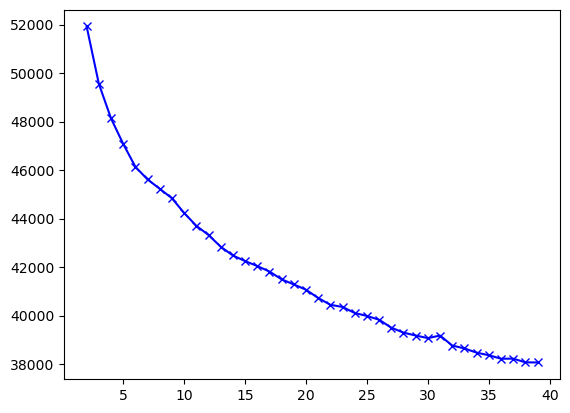

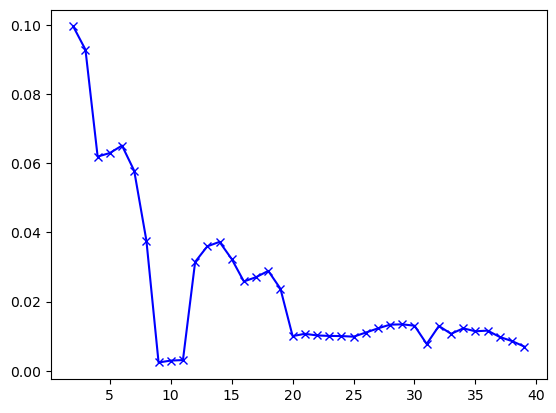

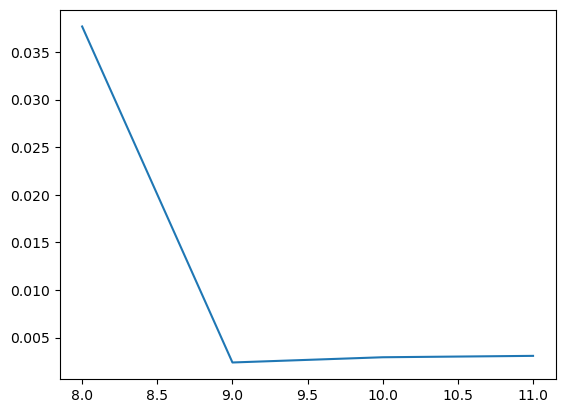

In [48]:
# Cluster into groups

stacked_meanings = np.vstack(vanity_plates_with_meaning_embeddings["meaning_embedding"])
max_clusters = 40
def test_kmeans_num_clusters(num_clusters):
    kmeans_model = KMeans(num_clusters, random_state=42)
    kmeans_model.fit(stacked_meanings)
    return kmeans_model.inertia_, silhouette_score(stacked_meanings, kmeans_model.labels_)

silhouette_score_avg = []
squared_distance_sums = []
for num_clusters in range(2, max_clusters):
    squared_distance_sum, silhouette_score_val = test_kmeans_num_clusters(num_clusters)
    squared_distance_sums.append(squared_distance_sum)
    silhouette_score_avg.append(silhouette_score_val)

plt.plot(range(2, max_clusters), squared_distance_sums, 'bx-')
plt.show()

plt.plot(range(2, max_clusters), silhouette_score_avg, "bx-")
plt.show()

plt.plot(range(8, 12), silhouette_score_avg[6:10])
plt.show()

In [24]:
classification_counts = vanity_plates_with_meanings_and_predicted_drop_na.groupby("predicted_meaning_majority_vote").count()

# Now, we want to convert this into a DataFrame with "count" as the column
# We will take the first column from the grouped DataFrame and rename it to "count"

classification_counts = classification_counts.iloc[:, [0]].reset_index()
classification_counts.columns = ['predicted_meaning_majority_vote', 'count']

classification_counts['percentage'] = (classification_counts['count']/len(vanity_plates_with_meanings_and_predicted_drop_na)) * 100

classification_counts

,predicted_meaning_majority_vote,count,percentage
0,Area code and Numbers,501,12.875867
1,Business and University Identities,17,0.436906
2,Colors and Descriptive Traits,61,1.567720
3,Diverse Personal Expressions,2000,51.400668
4,Gang Color and Controversial Affiliations,151,3.880750
5,Personal and Family names,65,1.670522
6,Pet and Animal Themes,255,6.553585
7,Vehicle and Car Descriptions and Attributes,841,21.613981


In [25]:
classification_counts = vanity_plates_with_meanings_and_predicted_drop_na.groupby("majority_vote").count()

# Now, we want to convert this into a DataFrame with "count" as the column
# We will take the first column from the grouped DataFrame and rename it to "count"

classification_counts = classification_counts.iloc[:, [0]].reset_index()
classification_counts.columns = ['majority_vote', 'count']

classification_counts['percentage'] = (classification_counts['count']/len(vanity_plates_with_meanings_and_predicted_drop_na)) * 100

classification_counts

,majority_vote,count,percentage
0,Area code and Numbers,322,8.275508
1,Business and University Identities,56,1.439219
2,Colors and Descriptive Traits,169,4.343356
3,Diverse Personal Expressions,1715,44.076073
4,Gang Color and Controversial Affiliations,180,4.626060
5,Personal and Family names,237,6.090979
6,Pet and Animal Themes,213,5.474171
7,Vehicle and Car Descriptions and Attributes,999,25.674634


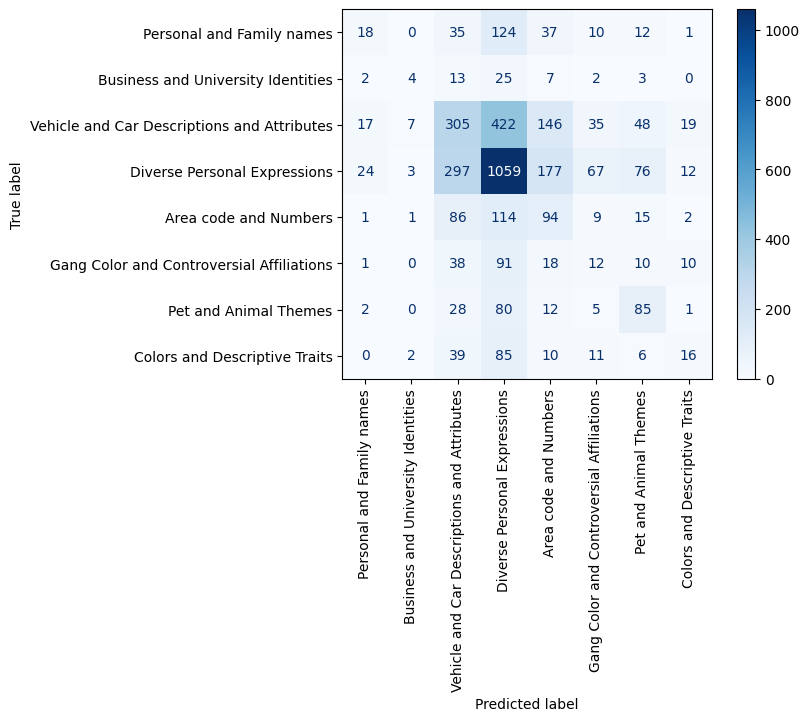

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cluster_labels = [
    "Personal and Family names",
    "Business and University Identities",
    "Vehicle and Car Descriptions and Attributes",
    "Diverse Personal Expressions",
    "Area code and Numbers",
    "Gang Color and Controversial Affiliations",
    "Pet and Animal Themes",
    "Colors and Descriptive Traits"
]

cm = confusion_matrix(vanity_plates_with_meanings_and_predicted_drop_na["majority_vote"], vanity_plates_with_meanings_and_predicted_drop_na["predicted_meaning_majority_vote"], labels=cluster_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cluster_labels)
disp.plot(cmap="Blues")

# Customize the x-axis labels to be vertical
plt.xticks(rotation=90)
plt.show()